# CNN Classifier Pipeline

<a href="https://colab.research.google.com/github/earthspecies/library/blob/master/giant_otter/cnn-classifier-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will go through the entire process of developing a pipeline for machine learning (ML)-based analysis of giant otter vocalizations. We will begin with data preprocessing, and we will proceed through all the steps required to build and train a CNN classifier model capable of labeling giant otter call types with a high degree of accuracy.

We'll begin with the initial data preprocessing step.

## Data Preprocessing

Now that we have our giant otter acoustics dataset (refer to README for the details and citations), our first step is data preprocessing. This is one of the most crucial steps in any ML pipeline, since we need to prepare a dataset that can readily be used to build and train ML models. When starting the data preprocessing procedure, it is important to keep sight of the final objective, since this can help us navigate the many possibilities for processing data. To begin, let's summarize our objective:

**Objective:** Train a CNN-based model to classify the call type of a given vocalization.

In order to accomplish this end goal, what ingredients do we need? 

* Inputs: spectrogram images for each signal
* Targets: labels corresponding to the call type contained in the spectrogram
* Training, validation, testing datasets: segmented datasets used to train and test the model

With these in mind, we can begin our data preprocessing stage with some usual imports:

In [1]:
import sys
if 'google.colab' in sys.modules:
  !pip install git+git://github.com/fastai/fastai2.git
  !pip install torchaudio
  !pip install soundfile
  !pip install livelossplot

from fastai2.vision.all import *

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import soundfile as sf
from matplotlib import mlab as mlab

### Loading the Data

The dataset of interest is hosted in partnership with the [Internet Archive](https://archive.org) 'https://archive.org/download/giant_otters/giant_otters.zip' as a compressed folder. We can use the fastai ``untar_data`` to access the data path:

In [2]:
path = untar_data('https://archive.org/download/giant_otters/giant_otters.zip')

Let's take a quick peak at what we are working with:

In [3]:
path.ls()

(#19) [Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S2.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S3.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S1.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S4.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S5.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Table_S3.xlsx'),Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S7.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Video_S6.mp4'),Path('/Users/peterbermant/.fastai/data/giant_otters/Audio_S2'),Path('/Users/peterbermant/.fastai/data/giant_otters/Table_S1.docx')...]

Great. We see that we have .mp4 videos, csv/xlsx spreadsheets, folders containing .wav audio files, and .docx documents with additional annotations. For this analysis, we are primarily focused on the raw audio files, especially those in the '/Audio S1' directory, so we will concentrate our attention on this folder. Restricting our data preprocessing in this way helps us to filter out some possible distractions and allows us to proceed more directly to our objective. Now, we will load the data and construct a Pandas ``DataFrame`` object in order to conveniently package some of the arrays we will likely use as we move forward. Let's define a function ``construct_df`` to build our ``DataFrame``.

In [4]:
def construct_df(path_location):
    labels = []
    
    waveforms, sampling_rates = [], []
    file_lengths_sec, file_lengths_f = [], []
    
    start_frames, end_frames = [], []
    
    for p in (path_location).ls().sorted():
        path_name = str(p)
        label = re.findall('\d_(.+)\.wav', path_name)[0]
        labels.append(label)
        
        wf, sr = sf.read(path_name)
        waveforms.append(wf)
        sampling_rates.append(sr)
        file_lengths_sec.append(len(wf) / sr)
        file_lengths_f.append(len(wf))
        
        find_frame = lambda array: next((i for i, x in enumerate(array) if x), None) 
        start_frame = find_frame(wf)
        start_frames.append(start_frame)
        end_frame = len(wf) - (find_frame(np.flip(wf)) + 1)
        end_frames.append(end_frame)
    
    d = {'label': labels, 'waveform': waveforms, 'sampling rate': sampling_rates, 'file length (s)': file_lengths_sec, 
        'file length (frames)': file_lengths_f, 'start frame': start_frames, 'end frame': end_frames}
    df = pd.DataFrame(data=d)
    
    return df

In [5]:
path_location = path / 'Audio_S1'
giant_otter_df = construct_df(path_location)
giant_otter_df.head()

,label,waveform,sampling rate,file length (s),file length (frames),start frame,end frame
0,bark,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",96000,0.369354,35458,4008,29875
1,bark,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",96000,0.419073,40231,9608,40230
2,bark,"[0.000396728515625, -0.000335693359375, -0.00091552734375, 9.1552734375e-05, 0.001129150390625, 0.0003662109375, 0.001068115234375, -0.000518798828125, -0.000396728515625, 0.00018310546875, -0.000152587890625, 0.0010986328125, -0.000213623046875, 0.00054931640625, 0.00030517578125, -0.000701904296875, -0.000396728515625, -0.001495361328125, -0.000946044921875, 0.0, -0.000274658203125, 0.00018310546875, 0.000244140625, 0.000946044921875, 0.000213623046875, 0.00042724609375, -0.001190185546875, 0.000732421875, 0.000762939453125, 0.000152587890625, 0.000823974609375, 9.1552734375e-05, 0.00091...",96000,0.350792,33676,0,29528
3,bark,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",96000,0.309667,29728,3840,29727
4,bark,"[0.000762939453125, 0.000732421875, 0.000762939453125, 0.000762939453125, 0.000762939453125, 0.000762939453125, 0.000762939453125, 0.000732421875, 0.000732421875, 0.000762939453125, 0.000762939453125, 0.000762939453125, 0.000732421875, 0.000732421875, 0.000732421875, 0.000732421875, 0.000732421875, 0.000732421875, 0.000732421875, 0.000732421875, 0.000701904296875, 0.000701904296875, 0.00067138671875, 0.00067138671875, 0.00067138671875, 0.00067138671875, 0.000640869140625, 0.000640869140625, 0.0006103515625, 0.000640869140625, 0.0006103515625, 0.000579833984375, 0.000579833984375, 0.0005798...",96000,0.284542,27316,0,19219


Awesome! We now have a conveniently packaged ``DataFrame`` object. Let's take a pause to inspect our function to see what's going on. First, we use regular expressions to extract the call type label using 

```python
label = re.findall('\d_(.+)\.wav', path_name)[0]```

If the path name looks something like '.fastai/data/giant_otters/Audio_S1/Audio S043_begging scream.wav', this will search the string for a digit followed by any character followed by '.wav' and will return the sequence of characters following the initial digit. For example:

In [6]:
example_path_name = '.fastai/data/giant_otters/Audio_S1/Audio S043_begging scream.wav'
re.findall('\d_(.+)\.wav', example_path_name)[0]

'begging scream'

Perfect, we can create the appropriate label for the given call contained in the .wav file. Moving on, we use the ``soundfile`` package to read the .wav files. We then identify important information in the waveforms, such as the duration of the signal, the length of the signal, and the start and end frames of the call in the signal, since some of the waveforms contain leading and tailing silences.

Now that we have our data packaged neatly, let's create a few arrays and dictionaries that will be useful moving forward.

In [7]:
def load_arrays_and_dicts(labels_array):
    unique_labels = np.unique(labels_array, return_counts=True)
    call_classes = unique_labels[0]
    
    call_class_dict = {call_label: i for i, call_label in enumerate(call_classes)}
    call_class_dict_inv = {value: key for key, value in call_class_dict.items()}
    
    call_class_counts = {c: n for c, n in zip(call_classes, unique_labels[1])}
    
    return call_classes, call_class_dict, call_class_dict_inv, call_class_counts

In [8]:
labels_array = giant_otter_df.label
call_classes, call_class_dict, call_class_dict_inv, call_class_counts = \
            load_arrays_and_dicts(labels_array)

print(f'Classes: \n {call_classes} \n')
print(f'Dictionary: \n {call_class_dict} \n')
print(f'Inverse Dictionary: \n {call_class_dict_inv} \n')
print(f'Class Counts: \n {call_class_counts}')

Classes: 
 ['Ascending scream' 'bark' 'begging call' 'begging scream'
 'begging scream gradation' 'close call' 'contact call'
 'contact call gradation' 'growl' 'hah' 'hum' 'hum gradation' 'hum short'
 'isolation call' 'snort' 'suckling call' 'underwater call'
 'wavering scream' 'whine' 'whistle' 'whistle double'] 

Dictionary: 
 {'Ascending scream': 0, 'bark': 1, 'begging call': 2, 'begging scream': 3, 'begging scream gradation': 4, 'close call': 5, 'contact call': 6, 'contact call gradation': 7, 'growl': 8, 'hah': 9, 'hum': 10, 'hum gradation': 11, 'hum short': 12, 'isolation call': 13, 'snort': 14, 'suckling call': 15, 'underwater call': 16, 'wavering scream': 17, 'whine': 18, 'whistle': 19, 'whistle double': 20} 

Inverse Dictionary: 
 {0: 'Ascending scream', 1: 'bark', 2: 'begging call', 3: 'begging scream', 4: 'begging scream gradation', 5: 'close call', 6: 'contact call', 7: 'contact call gradation', 8: 'growl', 9: 'hah', 10: 'hum', 11: 'hum gradation', 12: 'hum short', 13: 'isol

You might wonder why we care about all of these arrays and mappings. Well, it's definitely good to know what classes we are working with in general, but the dictionaries can be useful for carrying out and inverting a manual one-hot encoding. The class counts dictionary gives useful information, since it might be unrealistic to expect a model to learn the features of something like an 'underwater call', which has only 9 samples present in our dataset.

### A Fun Aside

Now that we have our dataframes and dictionaries, let's take a break to hear what these calls sound like! While this section is not expressly necessary for the ultimate objective, it's super fun to be able to listen to the sounds we are working with. It's also a very powerful way to stay connected to the animals and to the end mission of developing novel conservation techniques and strategies. Let's begin with some imports:

In [9]:
from IPython.lib.display import Audio
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
example_calls_df = giant_otter_df.groupby('label').apply(lambda df: df.sample(1))
example_calls_df = example_calls_df.reset_index(drop=True)
example_calls_df.head()

,label,waveform,sampling rate,file length (s),file length (frames),start frame,end frame
0,Ascending scream,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",96000,0.813698,78115,3099,78114
1,bark,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",96000,0.449906,43191,9491,43190
2,begging call,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",96000,0.455417,43720,9607,38919
3,begging scream,"[0.000762939453125, 0.00091552734375, 0.0013427734375, 0.0, 0.00067138671875, -3.0517578125e-05, -0.000579833984375, 0.000152587890625, -0.000244140625, 0.000885009765625, -9.1552734375e-05, -0.00048828125, -0.0001220703125, -0.00067138671875, 6.103515625e-05, -0.0003662109375, -3.0517578125e-05, 0.00042724609375, 0.000152587890625, 0.000152587890625, -0.00042724609375, -0.00054931640625, -0.00091552734375, -0.001373291015625, -0.0006103515625, 0.000152587890625, 0.000946044921875, 0.001220703125, 0.000762939453125, 0.000640869140625, 0.0, 0.00048828125, 9.1552734375e-05, -0.00048828125, 0...",96000,1.449240,139127,0,136265
4,begging scream gradation,"[-0.007080078125, 0.00494384765625, 0.0003662109375, -0.000518798828125, 0.005126953125, -0.002288818359375, 0.00653076171875, 0.002471923828125, 0.001068115234375, 0.0054931640625, -0.002655029296875, 0.000885009765625, -0.001068115234375, -0.007598876953125, -0.000518798828125, -0.0054931640625, -0.0015869140625, 0.000885009765625, -0.003173828125, 0.004608154296875, -0.000518798828125, 0.0, 0.00726318359375, 0.002655029296875, 0.004241943359375, 0.000701904296875, -0.000885009765625, 0.00140380859375, -0.00390625, 0.0, -0.001953125, -0.0067138671875, 0.002655029296875, -0.00424194335937...",96000,0.930156,89295,0,89294


In [11]:
@interact
def play_sounds(column=example_calls_df.label):
    idx = example_calls_df.label[example_calls_df.label == str(column)].index.tolist()[0]
    return Audio(example_calls_df.waveform.iloc[idx], rate=example_calls_df['sampling rate'].iloc[idx])

interactive(children=(Dropdown(description='column', options=('Ascending scream', 'bark', 'begging call', 'beg…

## Constructing Spectrograms

While there are a number of nuances to consider when constructing spectrograms, here we consider a naive straightforward approach since we are simply trying to develop a complete pipeline. The interested reader is invited to modify the code contained in this notebook in order to optimize our final model.

Before generating our dataset, let's start off by plotting examples of our call types to see example representations of giant otter calls. To do this, we'll define a function ``normalize_spectrogram``, which will ensure that our figure with spectrogram subplots will have a normalized colormap such that we can more reliably compare across the call types. For simplicity, we will use the entire sample signal rather than cutting the samples to equal frame lengths.

In [12]:
import matplotlib.gridspec as gridspec
%matplotlib inline

In [13]:
def normalize_spectrogram(wfs, srs):
    mins = []
    maxs = []
    for wf, sr in zip(wfs, srs):
        spec, _, _ = mlab.specgram(wf, Fs=sr)
        mins.append(np.min(spec))
        maxs.append(np.max(spec))
        
    min_val = 10 * np.log10(np.min(mins))
    max_val = 10 * np.log10(np.min(maxs))
    return min_val, max_val

wfs = example_calls_df.waveform.values
wfs = [wf[wf != 0] for wf in wfs]
srs = example_calls_df['sampling rate'].values

normalize_spectrogram(wfs, srs)

(-212.30872403322846, -39.06709852514224)

Now that we have a function to normalize the colormap scaling, let's proceed to plot the 21 call types contained in the dataset. Fortunately, our ``example_calls_df`` ``DataFrame`` object already contains single samples for each of the 21 classes, so we can use this to plot the call types in a 7x3 grid. For visualization purposes, we will explore two representations: (1) a time space representation in which we plot simply the waveform amplitude as a function of sample index (which is a multiplicative proxy of time) and (2) a time-frequency space representation in which we plot the spectrogram, offering insight into the time-varying spectrum of frequencies contained in the raw acoustic signal.

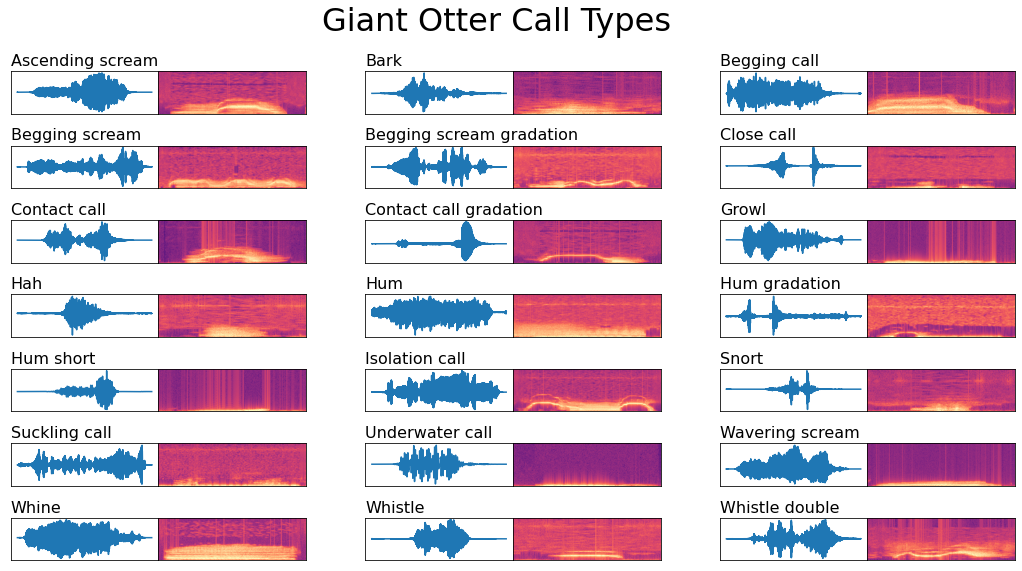

In [14]:
def plot_wfs_and_specs(labels, wfs, srs, plot_dim=[7, 3]):
    wfs_np = np.array(wfs)
    
    spec_min, spec_max = normalize_spectrogram(wfs_np, srs)
    
    fig = plt.figure(figsize=(18, 9))
    fig.suptitle('Giant Otter Call Types', fontsize=32)
    outer = gridspec.GridSpec(plot_dim[0], plot_dim[1], wspace=0.2, hspace=0.75)
    
    for i_idx, label in enumerate(labels):
        wf = wfs[i_idx]
        sr = srs[i_idx]
        
        inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i_idx], wspace=0.0, hspace=0.1)
        for j_idx in range(2):
            ax = plt.Subplot(fig, inner[j_idx])
            if j_idx == 0:
                ax.plot(wf, zorder=0)
                ax.set_title(label.capitalize(), loc='left', fontsize=16)
                ax.set_xticks([])
                ax.set_yticks([])
            elif j_idx== 1:
                pxx,  freq, t, cax = ax.specgram(wf, Fs=sr, cmap='magma', vmin=spec_min, vmax=spec_max)
                ax.set_xticks([])
                ax.set_yticks([])
                #fig.colorbar(cax, ax=ax)
            fig.add_subplot(ax)    
    plt.show()

wfs = example_calls_df.waveform.values
wfs = [wf[wf != 0] for wf in wfs]
srs = example_calls_df['sampling rate'].values
labels = example_calls_df.label
plot_wfs_and_specs(labels, wfs, srs)

This is off to a great start! We now have a visual representation of our acoustic signals. For our CNN-based classifier, we'll adopt a conventional approach and focus our attention on the spectrogram representations. Based on a visual inspection of the above plots, it seems reasonable to expect that a CNN model could reliably extract features enabling it to predict labels with a relatively high degree of accuracy.

Let's move on to constructing our image dataset. While we should formally create separate 'Training' and 'Testing' directories, for simplicity, we'll just create a single folder for our image data. With this in mind, we proceed by making a new directory, generating spectrograms using ``specgram`` and saving them with the filename ``'[CALL_TYPE]#.png'`` where the ``#`` is a counter index so that we don't overwrite existing files in the 'Image-Dataset' directory.

Lastly, it is important to observe that the various call types are not of fixed temporal duration. For instance, a 'Bark' is relatively transient whereas a 'Hum Gradation' extends for a comparatively longer time. Our straightforward methodology involves simply packaging the calls into a spectrogram image of fixed size, which interferes with the fidelity of the temporal representation of the signals. The motivated reader is challenged to modify the contents of this notebook in order to account for variable-length inputs. This could involve using techniques such as that described in Section 2.1 of [this paper](https://papers.nips.cc/paper/7965-unsupervised-cross-modal-alignment-of-speech-and-text-embedding-spaces.pdf]), adding zero-padding and/or noise to shorter call types, or trying other creative solutions.

We'll proceed with making an 'Image-Dataset' directory.

In [15]:
!mkdir 'Image-Dataset'

In [16]:
def generate_spectrogram(labels, waveforms, sampling_rates, directory='Image-Dataset', vis=True):
    class_label_index = {call_label: 0 for call_label in call_classes}
    
    wfs_np = np.array(waveforms)
    spec_min, spec_max = normalize_spectrogram(wfs_np, sampling_rates)
    
    for i, label in enumerate(labels):

        plt.figure(figsize=(1, 1))
        pxx, freq, t_bins, im = plt.specgram(waveforms[i], Fs=sampling_rates[i], cmap='magma', NFFT=256,
                                            vmin=spec_min, vmax=spec_max)
        plt.xticks([])
        plt.yticks([])
        filename = directory + '/' + label.capitalize() + str(class_label_index[label]) + '.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        if vis:
            plt.show()
        plt.close()
        class_label_index[label] += 1

labels = giant_otter_df.label
waveforms = giant_otter_df.waveform.values
waveforms = [waveform[waveform != 0] for waveform in waveforms]
sampling_rates = giant_otter_df['sampling rate']
generate_spectrogram(labels, waveforms, sampling_rates, directory='Image-Dataset', vis=False)

Bingo! We've now prepared our image dataset, which contains 441 spectrogram images labeled by the appropriate giant otter call type contained in the spectrogram. Time to load our data and build our CNN model!!

## Loading the Data

Now that we have preprocessed our data, it's time to load our data to prepare to build and train our CNN. First, let's import ``tensorflow`` and set a random seed for reproducibility:

In [17]:
import tensorflow as tf    
tf.random.set_seed(0)
np.random.seed(42)

Cool. Now we'll need to import our image files and assign them a label depending on the call type encoded in the spectrogram. Each image is saved with the file name './Call type#.png', which means that once again we can use regular expressions to find an expression contained within the string. With this in mind, we can define a method ``gen_label`` that is a function of the image file input:

In [18]:
def gen_label(image_file):
    label = re.findall('([a-zA-Z\s]+)\d+.png', image_file)[0]
    return label

example_filenames = ['CallType00.png', 'CallType0.png', 'Call Type00.png'] 
for ex in example_filenames:
    print(f'Label: {gen_label(ex)}')

Label: CallType
Label: CallType
Label: Call Type


Perfect! That's exactly what we where looking for. The expression ``'([a-zA-Z\s]+)\d+.png'`` tells us to search the file name for a sequence of one or more upper- or lowercase letters with spaces followed by one or more numerical digits and the '.png' file extension. The returned label will consist only of the sequence of letters and spaces. This means, for example, that the image file name 'Begging scream gradation27.png' will return 'Begging scream gradation', which is the desired label for this image.

Now that we have our categorical class labels, let's encode them via a one-hot representation:

In [19]:
def gen_one_hot_label(call_label, call_labels_list):
    call_labels_dict = {label:idx for idx, label in enumerate(call_labels_list)}
    one_hot_label = np.zeros(len(call_labels_list))
    one_hot_label[call_labels_dict[call_label]] = 1
    return one_hot_label

example_call_labels = ['A', 'B', 'C']
for l in example_call_labels:
    print(f'Categorical class label: {l}')
    print(f'     One-hot-encoded label: {gen_one_hot_label(l, example_call_labels)}')

Categorical class label: A
     One-hot-encoded label: [1. 0. 0.]
Categorical class label: B
     One-hot-encoded label: [0. 1. 0.]
Categorical class label: C
     One-hot-encoded label: [0. 0. 1.]


We are now completely ready to load our data. We need a few imports, and then we'll define our ``load_dataset`` function.

In [20]:
import os
import cv2
from tqdm import tqdm

In [21]:
def load_dataset(folder_name, call_labels_list):
    labeled_images_array = []
    
    regex_expression = '([a-zA-Z\s]+)\d+.png'
    regex_search = lambda x: re.findall(regex_expression, x)[0]
    
    for image_file_name in tqdm(os.listdir(folder_name)):
        call_label = regex_search(image_file_name)
        if call_label in call_labels_list:
            path = os.path.join(folder_name, image_file_name)
            image_file = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            image_file = cv2.resize(image_file, (64,64))
            labeled_images_array.append([np.array(image_file),
                gen_one_hot_label(call_label, call_labels_list)])
    random.seed(1)
    random.shuffle(labeled_images_array)
    return labeled_images_array

Let's take a pause to unpack what's happening in our ``load_dataset`` function. We start off by initializing a list ``labeled_images_array`` in which we will store the input ``X`` and target ``y`` data. We then define a ``lambda`` function ``regex_search`` that we will use to find and extract ``regex_expression`` in the image file name. The for-loop loops through all the files contained in the ``folder_name`` directory, extracts the call label from the image file name, and evaluates a conditional statement to see if the given call type is in the list that we are interested in classifying. We then read the image file, convert it to grayscale, resize it, and then package the image data and call label into the ``labeled_images_array``. The function then returns a shuffled version of this list. Let's apply this function to our ``Image-Dataset``, using vocalizations of type 'Begging call' and 'Bark'.

In [22]:
folder_name = 'Image-Dataset'
call_labels_list = ['Begging call', 'Bark']
labeled_images = load_dataset(folder_name, call_labels_list)

100%|██████████| 441/441 [00:00<00:00, 2206.30it/s]


Great! Now we've created an array that stores the images with their corresponding label. We can take a look at the shapes of the elements of the array to ensure the we have an object of shape ``(64, 64)`` that corresponds to the image array as well as an object of shape ``(2,)`` that reflects the one-hot-encoded label.

In [23]:
labeled_images[0][0].shape, labeled_images[0][1].shape

((64, 64), (2,))

We can now separate the ``labeled_images`` array into its constituent image inputs (X) and and target labels (y). We'll then split the data into separate training and validation datasets using the ``train_test_split`` method in ``sklearn.model_selection``.

In [24]:
image_data = np.array([i[0] for i in labeled_images]).reshape(-1,64,64,1)
image_labels = np.array([i[1] for i in labeled_images])

In [25]:
X = image_data
y = image_labels

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [26]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((35, 64, 64, 1), (7, 64, 64, 1), (35, 2), (7, 2))

Everything is all set! Time to build and train our CNN model using a Keras-based Sequential network.

## Building and Training the Model

In [27]:
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()

model.add(InputLayer(input_shape=[64,64,1]))
model.add(Conv2D(filters=32, kernel_size=5, strides=1, 
    padding='same', activation='sigmoid'))
model.add(MaxPool2D(pool_size=5, padding='same'))

model.add(Conv2D(filters=64, kernel_size=5, strides=1, 
    padding='same', activation='sigmoid'))
model.add(MaxPool2D(pool_size=5, padding='same'))

model.add(Conv2D(filters=64, kernel_size=5, strides = 1, 
    padding='same', activation='sigmoid'))
model.add(MaxPool2D(pool_size=5, padding = 'same'))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
optimizer = Adam(lr=1e-3)

model.compile(optimizer = optimizer, 
    loss = 'categorical_crossentropy', metrics=['accuracy'])
model_fitting = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
    epochs=110, batch_size=64, shuffle=False)

Using TensorFlow backend.


Train on 35 samples, validate on 7 samples
Epoch 1/110
35/35 [==============================] - 0s 13ms/step - loss: 0.6194 - accuracy: 0.7143 - val_loss: 0.7121 - val_accuracy: 0.4286
Epoch 2/110
35/35 [==============================] - 0s 2ms/step - loss: 0.8799 - accuracy: 0.4000 - val_loss: 0.7720 - val_accuracy: 0.4286
Epoch 3/110
35/35 [==============================] - 0s 2ms/step - loss: 0.8823 - accuracy: 0.4857 - val_loss: 0.7362 - val_accuracy: 0.4286
Epoch 4/110
35/35 [==============================] - 0s 2ms/step - loss: 0.7964 - accuracy: 0.5714 - val_loss: 0.7047 - val_accuracy: 0.4286
Epoch 5/110
35/35 [==============================] - 0s 2ms/step - loss: 0.8455 - accuracy: 0.4571 - val_loss: 0.6855 - val_accuracy: 0.5714
Epoch 6/110
35/35 [==============================] - 0s 2ms/step - loss: 0.9931 - accuracy: 0.3429 - val_loss: 0.6843 - val_accuracy: 0.5714
Epoch 7/110
35/35 [==============================] - 0s 2ms/step - loss: 0.8588 - accuracy: 0.4286 - val_loss:

Well that seems successful! Let's take a look at our training plots, which provide important insight into the network's learning behavior.

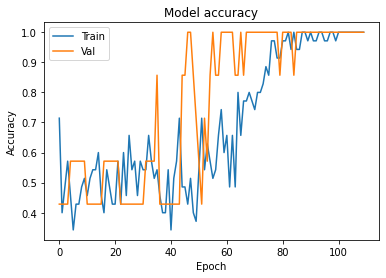

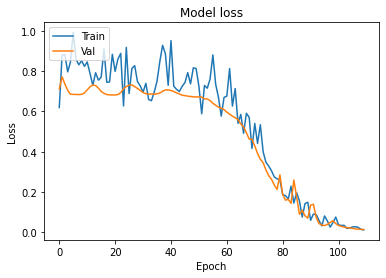

In [28]:
plt.plot(model_fitting.history['accuracy'])
plt.plot(model_fitting.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(model_fitting.history['loss'])
plt.plot(model_fitting.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Inspecting these plots, we can be reasonably confident that our network is learning meaningful representations of the data without overfitting our small dataset.

With a small dataset, it is often a challenge to segment data into training, validation, *and* testing datasets, so we'll evaluate the model using the entire dataset, having noted that the high validation accuracy and low loss combined with the ~monotonically decreasing validation loss curve provide some reassurance that we are not overfitting our training set.

Let's see what we get:

In [29]:
X_test, y_test = np.vstack((X_train, X_val)), np.vstack((y_train, y_val))
X_test.shape, y_test.shape

((42, 64, 64, 1), (42, 2))

In [30]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {scores[-1]*100}%')

Accuracy: 100.0%


Fantastic! Our final CNN-based classifier is able to label the call spectrograms with 100% accuracy!

Now that we have gone through the entire pipeline of preprocessing the data, loading the data, and building and training a model, let's take a deep dive into the model. With limitless options for constructing a CNN model, you might be wondering how we choose an architecture as well as some of the hyperparameters that help to define the model and the model training procedure. In general, this can involve an exhaustive grid search through a high-dimensional hyperparameter space, but for convenience, we'll offer an interactive GUI. We'll define a function ``build_and_train`` in which we will (obviously) build and train a CNN-based model, and then we'll use widgets so the interested reader can explore some possible options for hyperparameters.

## An Interactive GUI for Building and Training a CNN Model

In [31]:
from livelossplot import PlotLossesKeras
import warnings
warnings.simplefilter('ignore', UserWarning)

def build_and_train(n_conv_layer, learning_rate, epoch):
    
    conv_layer_counter = 0

    model = Sequential()
    model.add(InputLayer(input_shape=[64,64,1]))
    
    while conv_layer_counter < n_conv_layer:
        model.add(Conv2D(filters=64, kernel_size=5, strides=1, 
            padding='same', activation='sigmoid'))
        model.add(MaxPool2D(pool_size=5, padding='same'))
        conv_layer_counter += 1

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(lr=learning_rate)

    model.compile(optimizer = optimizer, 
        loss = 'categorical_crossentropy', metrics=['accuracy'])
    model_fitting = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
        epochs=epoch, batch_size=64, shuffle=False, verbose=0, callbacks=[PlotLossesKeras()])
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Accuracy: {scores[-1]*100}%')
    return model, model_fitting

In [32]:
style = {'description_width': 'initial'}

lrs = widgets.Dropdown(
    options=np.logspace(-4, 0, num=5), 
    value=1e-3,
    description='Learning Rate:',
    style=style)

eps = widgets.Dropdown(
    options=[1, 10, 25, 50, 100, 110, 125, 200, 500, 1000],
    value=125,
    description='Epochs:',
    style=style)

cls = widgets.Dropdown(
    options=[1, 2, 3, 5, 10, 100],
    value=3,
    description='Conv Layers:',
    style=style)

style = {'description_width': 'initial'}

@interact_manual(conv_layers=cls, learning_rates=lrs, epochs=eps)
def train_model(conv_layers, learning_rates, epochs):
    build_and_train(conv_layers, learning_rates, epochs)

interactive(children=(Dropdown(description='Conv Layers:', index=2, options=(1, 2, 3, 5, 10, 100), style=Descr…